# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
Artificial Intelligence has grown at a rapid rate in recent years, and has begun to creep into a myriad of industries for various uses. One such use is in medical imaging. Classification tasks are common in medical image analysis; it involves classifying medical images, such as X-rays, MRI scans, and CT scans, into different categories based on factors, like the type of image or the presence of specific structures/diseases. The aim is to use algorithms to classify medical images for assistance in diagnosis, treatment planning, and disease monitoring. The issue becomes how to correctly, or accurately, classify images - which is where deep learning models and neural networks come in handy.

This analysis will examine chest X-ray images of both healthy (referred to as "normal") and pneumonia-ridden patients in order to create a model that will accurately classify the two groups. The dataset comes from Kermany, Goldbaum et al.; and it is also available via Kaggle. The dataset is pre-split into training, testing, and validation directories, which makes loading and manipulating the data simple for my study. The data is also prepared in a way that makes it perfect for deep learning analysis (i.e. structured data with dimensions that don't require heavy processing). There are 5,216 images in the training directory (split into "NORMAL" and "PNEUMONIA" sub-directories), as well as 624 testing images and 16 validation images, both of which are split similarly to the training directory. I increased my validation dataset by splitting the testing data in order to train the model more effectively - this would have been tough with only 16 images. 

Once the data was loaded, I reshaped and standardized the training and validation images to prepare for modeling. I also reshaped their corresponding labels. Failing to standardize the dataset could have lead to skewed results, considering the wide range of the pixel values in the training data (e.g. \[0, 255] vs. \[0, 1] after standardizing). 

I used Keras, an effective high-level neural network (API), and TensorFlow, an end-to-end open-source deep learning framework that we run Keras on top of, in order to build my algorithms and determine the best model for image classification. I also used Scikit-learn, specifically the `KFold` validator, to cross-validate the baseline model, in order to determine a baseline accuracy level. Other modeling libraries used include `RMSNet50`, for transfer learning; `Conv2D` and `MaxPooling2D`, for a convolutional neural network; `ImageDataGenerator`, for data augmentation; and `ModelCheckpoint` along with `EarlyStopping`, to help save the best model. 

I began by building a baseline model - a neural network with two hidden layers - with hyperparameters I selected from prior research (i.e. RMSprop as my optimizer and binary cross-entropy for my loss). The next step was to use L2-regularization in order to combat the overfitting the former model exhibited. After, I used KFold to cross-validate the training model, and determined how effective my baseline is as a classifier model. I built a Convolutional Neural Network (CNN) next due to its effectiveness in classifying images, then augmented the training data in order to create more training data. More data allows the model to combat the high variance, and thus reduce the gap between the training and validation accuracies. I ended my modeling workflow with a transfer learning approach, specifically using the `RMSNet50` CNN pre-trained network to identify the surface patterns, before freezing the base and building another model to identify the abstract features in the training data. This approach also allows for data augmentation, paving the way for further improvement. 

The augmented CNN model yielded the best validation accuracy, while also remaining close enough to the training data's score that it avoided obvious overfitting. Luckily, the model was saved using the ModelCheckpoint technique, which was then applied to the testing images for evaluation. The model yielded 84.5% accuracy after testing 524 testing images, and exhibited the smallest margin of loss; however, there is much room for improvement and further work.

# Business Problem
Physicians and imaging labs are always looking for assistance in diagnosing illnesses, in order to improve treatment planning and health monitoring. The business objective is to build an algorithm that will accurately classify X-ray images (specifically chest images in this project) between two classes ("NORMAL" and "PNEUMONIA"). I'll be using data, available on Kaggle, that was gathered by Kermany, Goldbaum et al.
> Note: It is vital you run the `'validation_data_preparation.ipynb'` file prior to beginning this project, if you or another attempts to mimic the work. The file contains data preparation steps that are mentioned below. 

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

## Data Understanding
To begin, I import all the relevant libraries, and set a seed to be able to reproduce the results from this analysis. Next, I create objects containing the pathway for each directory so that I can begin examining the data. I use the `ImageDataGenerator` function I imported to generate the image data in each directory, and then split the datasets into two groups - images (input) and labels (output). 
> Note: In a separate notebook (`'validation_data_preparation.ipynb'`), I increased the number of validation images from 16 to 116 images, by using the `os` and `shutil` modules to move random files from the testing directories. 


In [1]:
# Import all the necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216,
                                                           seed=seed)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=524,
                                                           seed=seed)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=116,
                                                           seed=seed)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


As you can see above, there are 5,216 training images, 116 validation images (thanks to the initial data preparation), and 524 testing images. Now that the data has been loaded and split, I preview a couple of images as plots for a look at what I'll be working with.

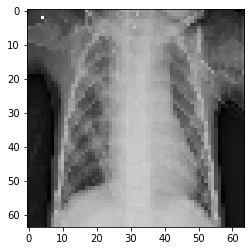

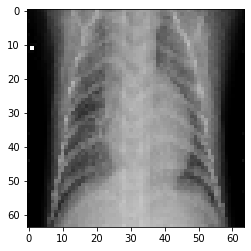

In [3]:
# Plot some images
plt.imshow(train_images[17]/255)
plt.show()

plt.imshow(train_images[4200]/255)
plt.show()

To get a better idea of my data, I also list the shape of both the images and labels for each dataset. As you can see, the images have four dimensions - the first is the number of images, the middle values represent the size of the images, and the fourth value represents the number of channels. 

In [4]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(524, 64, 64, 3)
(524, 2)

Validation Data Shape:
(116, 64, 64, 3)
(116, 2)


I also list the classes I will be working with in this analysis before reshaping the labels. Reshaping the classes now is only meant to examine whether the images truely correspond with their labels. I confirm this with the two following image plots, where the first accurately displays a "normal", or healthy, image, and the second displays an image for a pneumonia-ridden patient. 

In [5]:
# List the classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
# Reshape the labels
y_train_labels = train_labels.T[[1]]
y_test_labels = test_labels.T[[1]]
y_val_labels = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(y_train_labels))
print(np.shape(y_test_labels))
print(np.shape(y_val_labels))

(1, 5216)
(1, 524)
(1, 116)


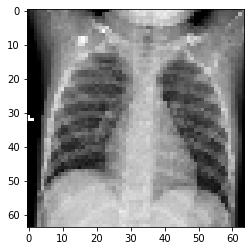

[0.]


In [7]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[1400]/255)
plt.show()
print(y_train_labels[:, 1400])

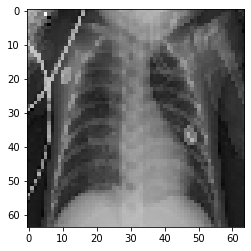

[1.]


In [8]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[14]/255)
plt.show()
print(y_train_labels[:, 14])

As one can see, not much data preparation was needed for data understanding. However, there is still a need to transform the data to prepare it for modeling, which is the next step.

## Modeling

### Baseline Model:
As I mentioned earlier, the training and validation images will need to be reshaped, along with their labels, so that they contain the same first dimension. In addition, I standardize the images by dividing by 255 (due to the range of pixel intensity values falling between \[0, 255]\).

In [9]:
# Reshape the train, test, and validation images for modeling
X_train = train_images.reshape(5216, -1)
X_test = test_images.reshape(524, -1)
X_val = val_images.reshape(116, -1)

# Preview the shape of each newly-formed objects
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(5216, 12288)
(524, 12288)
(116, 12288)


In [10]:
# Standardize the datasets
X_train_final = X_train/255
X_test_final = X_test/255
X_val_final = X_val/255

In [11]:
# Reshape the labels for modeling
y_train = np.reshape(train_labels[:, 0], (5216, 1))
y_test = np.reshape(test_labels[:, 0], (524, 1))
y_val = np.reshape(val_labels[:, 0], (116, 1))

# Check the shape of the transformed labels 
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(5216, 1)
(524, 1)
(116, 1)


Now that the data is fully manipulated, I begin building my baseline neural network by calling the `Sequential` function, then adding two `Dense` hidden layers with ReLu as my activation functions. I also pass in the input shape to create my input layer. The last layer acts as my output layer with a Sigmoid activation function. 

Once constructed, I compile the baseline model, using parameters I chose from prior research. Therefore, `RMSprop` and binary cross-entropy will act as my optimizer and loss functions, respectively. I preview the model summary in order to highlight the number of parameters being trained in each layer, and the shape of the output. 

In [12]:
# Create a dense baseline neural network
baseline_model = Sequential()
baseline_model.add(Dense(32, activation='relu', input_shape=(12288, )))
baseline_model.add(Dense(8, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [13]:
# Compile the baseline model
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

# List a summary of the baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                393248    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 393,521
Trainable params: 393,521
Non-trainable params: 0
_________________________________________________________________


There are 393,521 different parameters being trained in this network, but only 1 value will be output. I fit the model to the training data and labels, while also using the validation data to further validate these results. I also set the number of epochs to 50, with a 64 image batch size.

In [14]:
# Fit the baseline model
baseline = baseline_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 8ms/step - loss: 1.5002 - acc: 0.7122 - val_loss: 3.4271 - val_acc: 0.5000
Epoch 2/50
82/82 [==============================] - 0s 6ms/step - loss: 0.7443 - acc: 0.7885 - val_loss: 0.6295 - val_acc: 0.5000
Epoch 3/50
82/82 [==============================] - 0s 6ms/step - loss: 0.3969 - acc: 0.8133 - val_loss: 0.8646 - val_acc: 0.5431
Epoch 4/50
82/82 [==============================] - 0s 6ms/step - loss: 0.3336 - acc: 0.8553 - val_loss: 0.7836 - val_acc: 0.5948
Epoch 5/50
82/82 [==============================] - 1s 13ms/step - loss: 0.2858 - acc: 0.8848 - val_loss: 1.5222 - val_acc: 0.5259
Epoch 6/50
82/82 [==============================] - 1s 15ms/step - loss: 0.2538 - acc: 0.8965 - val_loss: 0.4018 - val_acc: 0.7931
Epoch 7/50
82/82 [==============================] - 1s 13ms/step - loss: 0.2243 - acc: 0.9059 - val_loss: 0.7872 - val_acc: 0.6293
Epoch 8/50
82/82 [==============================] - 1s 14ms/step - loss: 0.1979 - acc: 

In [15]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{baseline_model.evaluate(X_train_final, y_train)}')
print('\n')
print(f'Validation data results:\n{baseline_model.evaluate(X_val_final, y_val)}')

163/163 [==============================] - 1s 4ms/step - loss: 0.1359 - acc: 0.9413
Training data results:
[0.1359104961156845, 0.9413343667984009]


4/4 [==============================] - 0s 2ms/step - loss: 0.6537 - acc: 0.7500
Validation data results:
[0.6537246704101562, 0.75]


The baseline results above generated a 94.1% accuracy rate for the training data, but only 75.0% for the validation data, which implies the model is overfitting to the training data. To get a better idea, I create a function that will visualize my training results going forward, and apply it to the baseline model.

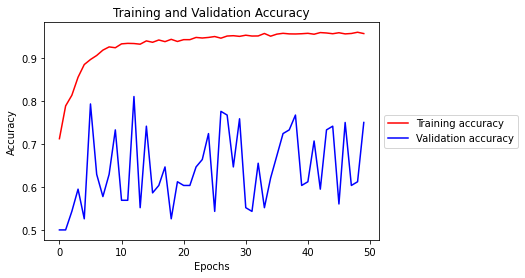

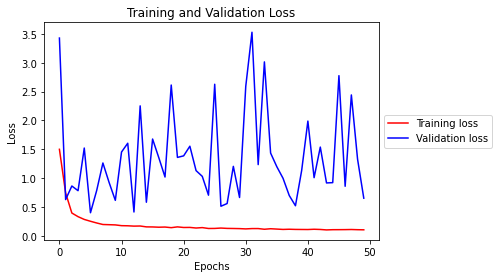

In [16]:
# Create a function that will visualize the training results for both datasets
def visualize_training_results(results):
    acc = results.history['acc']
    val_acc = results.history['val_acc']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

visualize_training_results(baseline)

The visuals above further confirm the overfitting theory. The top graph shows how large a gap the accuracies between both datasets really are, which supports our findings. In order to eliminate the overfitting, I must tune the model.

### Regularizing the Baseline Model:
In order to reduce overfitting to the training data, I apply lasso (L2) regularization, specifically with a penalty of 0.01. The network architecture remains similar to the baseline's framework, with the exception of the L2 regularizer addition in the `kernel_regularizer` parameter. I fit the model with the same number of epochs and batch size, and evaluate the model with the validation data. 

In [17]:
# Regularize the baseline model
regularized_model = Sequential()
regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
regularized_model.add(Dense(8, activation='relu'))
regularized_model.add(Dense(1, activation = 'sigmoid'))
regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
results = regularized_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 16ms/step - loss: 1.1065 - acc: 0.6844 - val_loss: 1.0651 - val_acc: 0.5000
Epoch 2/50
82/82 [==============================] - 1s 14ms/step - loss: 0.7087 - acc: 0.7327 - val_loss: 0.7203 - val_acc: 0.5000
Epoch 3/50
82/82 [==============================] - 1s 14ms/step - loss: 0.6492 - acc: 0.7617 - val_loss: 0.8815 - val_acc: 0.5000
Epoch 4/50
82/82 [==============================] - 1s 15ms/step - loss: 0.6818 - acc: 0.7613 - val_loss: 4.5950 - val_acc: 0.5000
Epoch 5/50
82/82 [==============================] - 1s 12ms/step - loss: 0.8920 - acc: 0.7331 - val_loss: 0.6309 - val_acc: 0.7069
Epoch 6/50
82/82 [==============================] - 1s 11ms/step - loss: 1.1419 - acc: 0.6925 - val_loss: 0.9761 - val_acc: 0.5000
Epoch 7/50
82/82 [==============================] - 1s 11ms/step - loss: 0.7646 - acc: 0.7222 - val_loss: 0.8109 - val_acc: 0.5000
Epoch 8/50
82/82 [==============================] - 1s 11ms/step - loss: 0.7224 - a

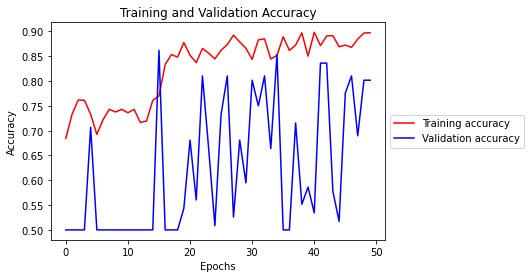

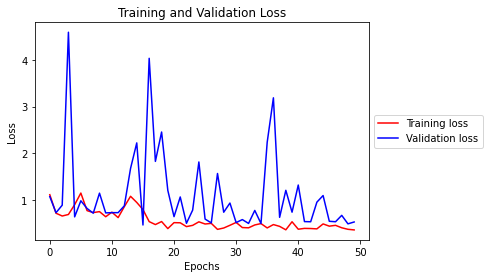

In [18]:
# Visualize the training results
visualize_training_results(results)

Much better! I see that the data is no longer overfitting on the training data, and even more - the graphs for both datasets follow each other more closely (especially the loss line graph). Albeit far from perfect, the baseline model has improved considerably, and I will cross-validate the results with Scikit-learn's `KFold` technique to see how generalizable this model is.

### Cross-Validating the Regularized Baseline Model:

I create a function that will build the regularized baseline model in order to cross-validate on it with `KFold`.

In [19]:
# Create a function that will build the regularized model above
def build_reg_model():
    regularized_model = Sequential()
    regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
    regularized_model.add(Dense(8, activation='relu'))
    regularized_model.add(Dense(1, activation = 'sigmoid'))
    regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
    return regularized_model

I utilize SciKeras, which combines Scikit-learn's machine learning capabilities to further improve Keras's ability to build deep learning models. I'll use `KFold` to cross-validate and produce the average validation score.

In [20]:
# Cross-validate using scikit-learn tools
keras_model = scikit_learn.KerasClassifier(build_reg_model,
                                          epochs=32,
                                          batch_size=64,
                                          verbose=2)
kfold = KFold(shuffle=True, random_state=seed)
validation_scores = cross_val_score(keras_model, X_train_final, y_train, cv=kfold)

Epoch 1/32
66/66 - 1s - loss: 0.8471 - acc: 0.7332
Epoch 2/32
66/66 - 1s - loss: 0.6058 - acc: 0.7529
Epoch 3/32
66/66 - 1s - loss: 0.5346 - acc: 0.8015
Epoch 4/32
66/66 - 1s - loss: 0.6220 - acc: 0.7744
Epoch 5/32
66/66 - 1s - loss: 0.5925 - acc: 0.7982
Epoch 6/32
66/66 - 1s - loss: 0.5295 - acc: 0.8198
Epoch 7/32
66/66 - 1s - loss: 0.5055 - acc: 0.8296
Epoch 8/32
66/66 - 1s - loss: 0.5791 - acc: 0.8248
Epoch 9/32
66/66 - 1s - loss: 0.4643 - acc: 0.8420
Epoch 10/32
66/66 - 1s - loss: 0.4895 - acc: 0.8356
Epoch 11/32
66/66 - 1s - loss: 0.4775 - acc: 0.8466
Epoch 12/32
66/66 - 1s - loss: 0.5155 - acc: 0.8437
Epoch 13/32
66/66 - 1s - loss: 0.4769 - acc: 0.8552
Epoch 14/32
66/66 - 1s - loss: 0.4974 - acc: 0.8411
Epoch 15/32
66/66 - 1s - loss: 0.4842 - acc: 0.8425
Epoch 16/32
66/66 - 1s - loss: 0.4786 - acc: 0.8497
Epoch 17/32
66/66 - 1s - loss: 0.4270 - acc: 0.8710
Epoch 18/32
66/66 - 1s - loss: 0.4450 - acc: 0.8598
Epoch 19/32
66/66 - 1s - loss: 0.4082 - acc: 0.8720
Epoch 20/32
66/66 - 1

Epoch 29/32
66/66 - 1s - loss: 0.6345 - acc: 0.7254
Epoch 30/32
66/66 - 1s - loss: 0.5472 - acc: 0.7457
Epoch 31/32
66/66 - 1s - loss: 0.6137 - acc: 0.7688
Epoch 32/32
66/66 - 1s - loss: 0.5351 - acc: 0.7930
17/17 - 0s - loss: 0.3522 - acc: 0.8917


In [21]:
# Calculate the training data's average validation score
validation_scores.mean()

0.8746062994003296

Our baseline model has improved slightly - not only did the overfitting issue get solved, but the validation score is .875, suggesting this model's performance has improved. This baseline model is a great foundation and tool for comparison. 

## Further Modeling
### Convolutional Neural Network (CNN):
The next model I'd like to apply is a Convolutional Neural Network (CNN). The benefits to CNN models are that they're regularized, and are very efficient in analyzing image data. I start with my `Sequential` function, but then apply 3 convolutional layers with two different kernel shapes (`(3, 3)` and `(4, 4)`), and ReLu activation functions. After building my base, I apply `Flatten` and two `Dense` functions to produce a hidden layer before my output layer. I compile and fit the model before visualizing the results.

In [22]:
# Construct the CNN model's framework
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(1, activation='sigmoid'))

CNNmodel.compile(loss='binary_crossentropy',
              optimizer="RMSprop",
              metrics=['acc'])

In [23]:
# Fit the CNN model
CNNresults = CNNmodel.fit(train_images,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, y_val))

Epoch 1/50
163/163 [==============================] - 17s 105ms/step - loss: 2.1736 - acc: 0.7866 - val_loss: 0.5675 - val_acc: 0.7500
Epoch 2/50
163/163 [==============================] - 17s 104ms/step - loss: 0.2653 - acc: 0.9110 - val_loss: 0.8731 - val_acc: 0.7586
Epoch 3/50
163/163 [==============================] - 17s 103ms/step - loss: 0.1987 - acc: 0.9352 - val_loss: 2.2381 - val_acc: 0.6034
Epoch 4/50
163/163 [==============================] - 17s 104ms/step - loss: 0.1462 - acc: 0.9517 - val_loss: 3.0612 - val_acc: 0.5862
Epoch 5/50
163/163 [==============================] - 17s 105ms/step - loss: 0.1437 - acc: 0.9590 - val_loss: 1.4256 - val_acc: 0.6897
Epoch 6/50
163/163 [==============================] - 17s 104ms/step - loss: 0.1055 - acc: 0.9680 - val_loss: 1.3989 - val_acc: 0.7759
Epoch 7/50
163/163 [==============================] - 17s 104ms/step - loss: 0.1092 - acc: 0.9674 - val_loss: 2.0495 - val_acc: 0.6466
Epoch 8/50
163/163 [==============================] - 1

The plots below exhibit some overfitting, once again. The accuracy plot shows a wide gap between the training and validation accuracies, while the loss plots show the training loss increasing as the number of epochs does too. Therefore, while the CNN model has improved the scores, the overfitting is still an issue. With CNN algorithms having built-in regularization methods, I'll look to combat this overfitting by adding more data. 

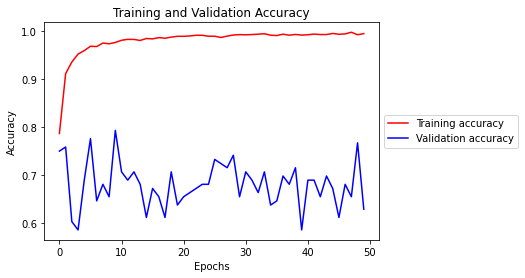

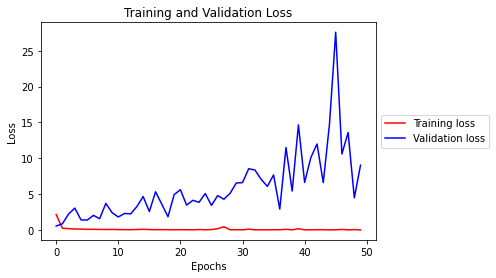

In [24]:
# Visualize the training results
visualize_training_results(CNNresults)

### Data Augmentation
In order to improve my model further, I'll increase my training size by applying data augmentation. Considering the images are X-rays, I select my parameters within `ImageDataGenerator` carefully and logically (i.e., increasing brightness to better detect abstract features, zooming in, flipping the image, etc.). I'll reload the training images with these new parameters, as well as the validation and test images (which will also be standardized). 

In [25]:
# Reshape the training data for augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=[1, 1.5], 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

In [26]:
# Get all the data in the training directory (in batches) and standardize
train_generator_aug = train_datagen.flow_from_directory(
    train_data_dir, target_size=(64, 64), 
    batch_size=32, seed=seed, class_mode='binary')

# Get all the data in the test directory and standardize
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir, target_size=(64, 64), 
    batch_size = 524, seed=seed, class_mode='binary') 

# Get all the data in the validation directory (in batches) and standardize
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir, target_size=(64, 64),
    batch_size = 32, seed=seed, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


Now that the images have been loaded again, I will rebuild my CNN model; however, I will also alter the learning rate in order to improve my CNN model further. 

In [27]:
# Build a CNN model framework using the augmented training data
augCNNmodel = Sequential()
augCNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Flatten())
augCNNmodel.add(Dense(64, activation='relu'))
augCNNmodel.add(Dense(1, activation='sigmoid'))

augCNNmodel.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

I'm also going to create a stopping condition, due to the runtime given the size of the dataset and number of epochs. I'll set that stopping point as a checkpoint with `ModelCheckpoint`, so that I can evaluate the saved model further along the process. Once my conditions have been set, I'll fit the model with these callbacks.

In [28]:
# Create a file name object for the best model checkpoint
model_filepath = 'best_aug_model.h5'

# Set early stopping and model checkpoint conditions
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [29]:
# Fit the data-augmented CNN model
augCNNresults = augCNNmodel.fit(train_generator_aug,
                                epochs=32,
                                callbacks=early_stopping,
                                validation_data=val_generator)

Epoch 1/32
163/163 [==============================] - 90s 552ms/step - loss: 0.5465 - acc: 0.7427 - val_loss: 0.6534 - val_acc: 0.5948
Epoch 2/32
163/163 [==============================] - 90s 551ms/step - loss: 0.4687 - acc: 0.7686 - val_loss: 0.6297 - val_acc: 0.6207
Epoch 3/32
163/163 [==============================] - 91s 558ms/step - loss: 0.4226 - acc: 0.7916 - val_loss: 0.5336 - val_acc: 0.7586
Epoch 4/32
163/163 [==============================] - 89s 546ms/step - loss: 0.4010 - acc: 0.8069 - val_loss: 0.5146 - val_acc: 0.7845
Epoch 5/32
163/163 [==============================] - 89s 544ms/step - loss: 0.3850 - acc: 0.8253 - val_loss: 0.5394 - val_acc: 0.6724
Epoch 6/32
163/163 [==============================] - 89s 547ms/step - loss: 0.3731 - acc: 0.8263 - val_loss: 0.5383 - val_acc: 0.6724
Epoch 7/32
163/163 [==============================] - 89s 544ms/step - loss: 0.3583 - acc: 0.8330 - val_loss: 0.5038 - val_acc: 0.7759
Epoch 8/32
163/163 [==============================] - 9

The data-augmented CNN model stopped at 13 epochs, suggesting that is the best point in the model where the validation loss plateaus. The model is saved as `'best_aug_model.h5'`, and I'll load the model in order to evaluate both the training and validation datasets.

In [30]:
# Load the best (saved) model for the augmented data
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(train_generator_aug)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_generator)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

163/163 [==============================] - 81s 498ms/step - loss: 0.3088 - acc: 0.8662
Training Loss: 0.309 
Training Accuracy: 0.866
----------
4/4 [==============================] - 1s 312ms/step - loss: 0.4453 - acc: 0.8276
Validation Loss: 0.445 
Validation Accuracy: 0.828


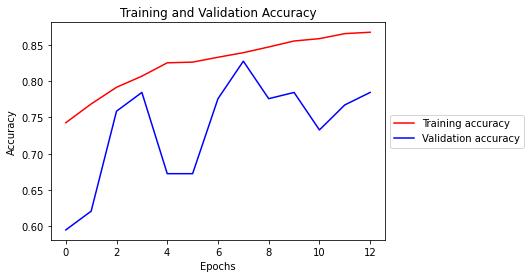

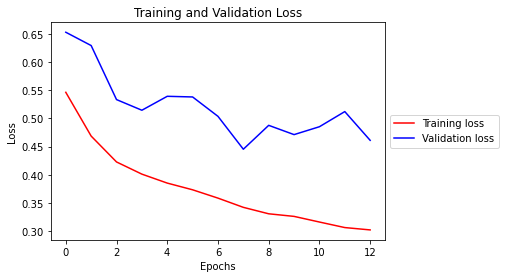

In [31]:
# Plot the training results
visualize_training_results(augCNNresults)

What an improvement! Not only did the training data show 86.6% accuracy, the validation data yielded similar results with almost 83% accuracy. The small gap between the two scores isn't surprising, given that CNN models are regularized in nature, and thus are not prone to overfitting easily. What's more surprising is the growth in accuracy between this model and our baseline, further proving how efficient CNN models are in image classification. 

I also visualize the training results above. One can see the validation metrics are plotted much cleaner, and with less "noise". The two metrics seem to almost mimic each other in their directions, suggesting this is a good model for the task at hand.

### Transfer Learning Approach:
One last approach I want to test out is the transfer learning approach. Transfer learning allows me to utilize pre-trained networks as a base to my model, with the option to build additional layers for specific feature extraction or fine tuning. I researched various pre-trained networks available, and selected `ResNet50` due to its high accuracy and application in medical imaging. 

I print the summary, after instantiating the network, to examine the number of parameters my model will be training - shown to be 23,534,592 parameters!

In [32]:
# Instantiate the CNN base object
cnn_base = ResNet50(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

# Preview the various parameters that will be trained
cnn_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

After building the CNN base, I add additional layers (specifically 1 hidden and the output) in order to better analyze the more abstract features within my images. Then, I freeze the base model, and compile my model to fit on the training data (and evaluated by the validation data). I list all the trainable layers and weights as a sanity check to review my work.

In [33]:
# Build a network with the CNN base
resnet_model = Sequential()
resnet_model.add(cnn_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

# Freeze the base model
cnn_base.trainable = False

# List all the trainable layers
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, check how many trainable weights are in the model 
print(f'Trainable weights: {len(resnet_model.trainable_weights)}\n')

# Preview the various parameters and output shapes, once again
resnet_model.summary()

resnet50 False
flatten_2 True
dense_25 True
dense_26 True
Trainable weights: 4

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 2,097,665
Non-trainable params: 23,587,712
_________________________________________________________________


> Note: I only run the model for 10 epochs in order to cut on the training time.

In [34]:
# Compile the transfer learning model
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=.001),
              metrics=['acc'])

# Fit the model
resnet_results = resnet_model.fit(train_generator_aug,
                              epochs=10,
                              validation_data=val_generator)

Epoch 1/10
163/163 [==============================] - 119s 732ms/step - loss: 0.5153 - acc: 0.7651 - val_loss: 0.6654 - val_acc: 0.6121
Epoch 2/10
163/163 [==============================] - 120s 736ms/step - loss: 0.4452 - acc: 0.7908 - val_loss: 0.5997 - val_acc: 0.6207
Epoch 3/10
163/163 [==============================] - 121s 739ms/step - loss: 0.4344 - acc: 0.7928 - val_loss: 0.5873 - val_acc: 0.6207
Epoch 4/10
163/163 [==============================] - 119s 732ms/step - loss: 0.4129 - acc: 0.8083 - val_loss: 0.4626 - val_acc: 0.7845
Epoch 5/10
163/163 [==============================] - 111s 681ms/step - loss: 0.4090 - acc: 0.8092 - val_loss: 0.5649 - val_acc: 0.6983
Epoch 6/10
163/163 [==============================] - 114s 698ms/step - loss: 0.4057 - acc: 0.8102 - val_loss: 0.7073 - val_acc: 0.5948
Epoch 7/10
163/163 [==============================] - 122s 748ms/step - loss: 0.3975 - acc: 0.8121 - val_loss: 0.6301 - val_acc: 0.6034
Epoch 8/10
163/163 [============================

Now that the model has been run, I plot the training results with different markers to better exhibit how the model performed.

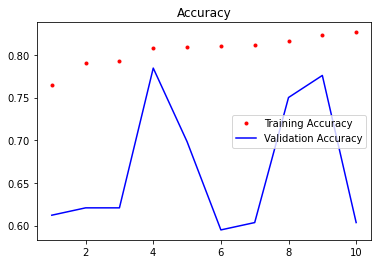

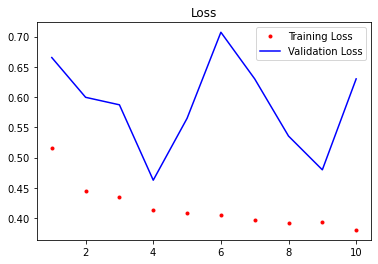

In [35]:
# Plot the training results using different markers
resnet_train_acc = resnet_results.history['acc']
resnet_val_acc = resnet_results.history['val_acc']
resnet_train_loss = resnet_results.history['loss']
resnet_val_loss = resnet_results.history['val_loss']
epch = range(1, len(resnet_train_acc) + 1)

plt.plot(epch, resnet_train_acc, 'r.', label='Training Accuracy')
plt.plot(epch, resnet_val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, resnet_train_loss, 'r.', label='Training Loss')
plt.plot(epch, resnet_val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

As shown above, the transfer learning model did worse than our CNN model, even with the data augmentation approach! The validation accuracy and loss gets "noisier", and alternates between decreasing and increasing slopes. Compared to the training data, the validation data suggests the model needs to be tuned further, or perhaps needs another pre-trained network to build off of.

## Deployment & Evaluation
After reviewing the training and validation scores, I've determined the CNN model with the augmented data is the best at classifying my X-ray images. Fortunately, this model was saved by `ModelCheckpoint`, and loaded earlier in the notebook; therefore, evaluating the testing dataset is simple.

In [37]:
# Evaluate the test data and list testing accuracy
test_loss, test_acc = saved_model.evaluate(test_generator)
y_hat_test = saved_model.predict(test_generator)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

1/1 [==============================] - 0s 2ms/step - loss: 0.4150 - acc: 0.8454
Generated 524 predictions
test acc: 0.8454198241233826


My saved model is 84.5% accurate after analyzing the testing data, which is decent but obviously leaves room for improvement. Below I plot the confusion matrix to get a further look at how the model performed. 

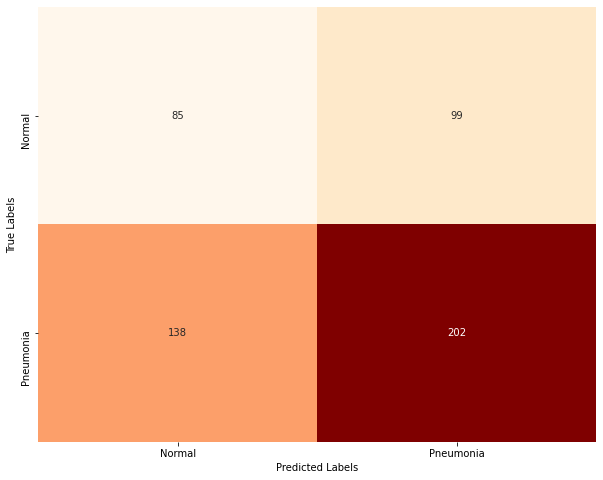

In [38]:
# Set conditions to make plotting the confusion matrix easier
y_test = test_generator.classes
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test < 0.5] = 0

# Plot a confusion matrix of the test data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True,
           fmt='.3g', xticklabels=['Normal', 'Pneumonia'],
           yticklabels=['Normal', 'Pneumonia'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The visual above shows this model still has room for improvement, especially in its false negative count (predicting "Normal" when the patient actually has pneumonia!). However, after some further tuning, I'm confident the model can be generalized to a level where physicians and image labs can utilize it.

## Conclusion

This analysis leads to the following conclusions:

1. The Convolutional Neural Network (CNN) model performs the best in image classification; specifically, when the data has been augmented. 


2. The model is 84.5% accurate when testing and classifying chest X-ray images for pneumonia.

## Limitations & Further Work

This project is limited in a few ways, the first being the lack of data. It wasn't until I augmented my data that the model began to train better, and yield efficient results. If given more image data, the model could effectively learn more of the abstract features within the X-ray images to better identify between the two groups of patients. In addition, the computer I'm running my model on lacks the strength to iterate the model with more epochs. If I were to increase my epochs, or even add additional layers to my model, I could potentially improve my results. There are other hyperparameters I could test, as well, which might also improve the algorithm's performance.

Further analyses could yield a more effective classifier, and possibly improve the algorithm's performance. Some possible courses of action I could take include training with other pre-trained networks. The research I found led me to pre-select a base model; however, I could train a few more that may examine the training images better, and improve my results. In addition, I could increase my validation data further, which would reduce the amount of "noise" shown in my visuals for the validation data's metrics, but also give me a better idea on how to further develop my classifier.